In [1]:
import pandas as pd
import numpy as nm

#for Label Encoding
from sklearn.preprocessing import LabelEncoder

#for Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#for Data splitting
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

# Data Loading

##### 50% - 50% : legitimate links - Malicious links

In [2]:
# Dataset from kaggle (https://www.kaggle.com/shashwatwork/web-page-phishing-detection-dataset)
# 50% - 50% : legitimate URLs - Malicious URLs

df = pd.read_csv(r'C:\Users\Acer\Desktop\Major Project\Machine Learning Models\Dataset\dataset_phishing.csv')
df.shape

(11430, 89)

In [3]:
df

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11425,http://www.fontspace.com/category/blackletter,45,17,0,2,0,0,0,0,0,...,0,0,0,448,5396,3980,0,0,6,legitimate
11426,http://www.budgetbots.com/server.php/Server%20...,84,18,0,5,0,1,1,0,0,...,1,0,0,211,6728,0,0,1,0,phishing
11427,https://www.facebook.com/Interactive-Televisio...,105,16,1,2,6,0,1,0,0,...,0,0,0,2809,8515,8,0,1,10,legitimate
11428,http://www.mypublicdomainpictures.com/,38,30,0,2,0,0,0,0,0,...,1,0,0,85,2836,2455493,0,0,4,legitimate


# Pre-processing

##### Dropping duplicate values in dataset

In [4]:
df=df.drop_duplicates(keep='first')

##### Dropping useless columns

In [5]:
df.drop(df.columns.difference(['url','status']), 1, inplace=True)
df

,url,status
0,http://www.crestonwood.com/router.php,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,phishing
2,https://support-appleld.com.secureupdate.duila...,phishing
3,http://rgipt.ac.in,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate
...,...,...
11425,http://www.fontspace.com/category/blackletter,legitimate
11426,http://www.budgetbots.com/server.php/Server%20...,phishing
11427,https://www.facebook.com/Interactive-Televisio...,legitimate
11428,http://www.mypublicdomainpictures.com/,legitimate


##### Encoding status column

In [6]:
status_encoder = LabelEncoder()

status_encoder.fit(df['status'])
df['status_enc'] = status_encoder.transform(df['status'])

df.drop(['status'],axis =1,inplace=True)

# Features Extraction from dataframe

### Lexical based features

In [7]:
def count_length(url): # 1.counting length of URL 
    #Bucket size : 37 in accordance http://www.supermind.org/blog/740/average-length-of-a-url-part-2
    if len(url)<=37:
        return 0
    elif len(url)>=38 and len(url)<=74:
        return 1
    else:
        return 2
    
def count_dots(url): # 2.counting dots in URL
    dot_count = url.count('.')
    return dot_count

def count_slash(url): # 3.counting slash in URL
    slash_count = url.count('/')
    return slash_count

def count_hyphen(url): # 4.counting hyphen in URL
    hyphen_count = url.count('-')
    return hyphen_count

def count_at(url): # 5.counting @ in URL
    at_count = url.count('@')
    return at_count

def count_underline(url): # 6.counting underline in URL
    underline_count = url.count('_')
    return underline_count

def count_plus(url): # 7.counting + in URL
    plus_count = url.count('+')
    return plus_count

def count_hashtag(url): # 8.counting # in URL
    hashtag_count = url.count('#')
    return hashtag_count

def count_digits(url): # 9.counting digits present in URL
    digit_count = 0
    for i in url:
        if i.isdigit():
            digit_count=digit_count+1
    return digit_count

def count_special(url): #10. counting special characters present in URL
    special=0
    for i in url:
        if(url.isalpha()==0 and url.isdigit()==0):
            special = special + 1
    return special

def count_percentage(url): # 11.counting % in URL
    percentage_count = url.count('=')
    return percentage_count 

def count_equal(url): # 12.counting = in URL
    equal_count = url.count('=')
    return equal_count   

def count_and(url): # 13.counting & in URL
    and_count = url.count('&')
    return and_count

In [8]:
def lexicalFeatureExtraction(url,label):
    lexical_features = []
    
    #Lexical Features
    lexical_features.append(count_length(url)) #1
    lexical_features.append(count_dots(url)) #2
    lexical_features.append(count_slash(url)) #3
    lexical_features.append(count_hyphen(url)) #4
    lexical_features.append(count_at(url)) #5
    lexical_features.append(count_underline(url)) #6
    lexical_features.append(count_plus(url)) #7
    lexical_features.append(count_hashtag(url)) #8
    lexical_features.append(count_digits(url)) #9
    lexical_features.append(count_special(url)) #10
    lexical_features.append(count_percentage(url)) #11
    lexical_features.append(count_equal(url)) #12
    lexical_features.append(count_and(url)) #13
    
    return lexical_features

In [9]:
featuresLexical = []
label = 0

for i in range(0, 11430):
    url_value = df['url'][i]
    featuresLexical.append(lexicalFeatureExtraction(url_value,label))
    
lexical_labels = ['url_length','url_dot', 'url_slash', 'url_hyphen', 'url_at', 'url_underline','url_plus','url_hashtag', 
                  'url_digits', 'url_special', 'url_percent', 'url_equal', 'url_and']

lexical_df = pd.DataFrame(featuresLexical, columns=lexical_labels)
lexical_df.head()

,url_length,url_dot,url_slash,url_hyphen,url_at,url_underline,url_plus,url_hashtag,url_digits,url_special,url_percent,url_equal,url_and
0,0,3,3,0,0,0,0,0,0,37,0,0,0
1,2,1,5,0,0,0,0,0,17,77,0,0,0
2,2,4,5,1,0,2,0,0,19,126,3,3,2
3,0,2,2,0,0,0,0,0,0,18,0,0,0
4,1,2,5,2,0,0,0,0,0,55,0,0,0


In [10]:
daf = pd.concat([df, lexical_df], axis=1)

### Domain Based Features

In [11]:
from urllib.parse import urlparse
from tldextract import extract
import tldextract
import re

In [12]:
# def extracting_domain(url):
#     domain = urlparse(url).netloc
#     return domain

def domain_length(url): # 1.Domain Length
    # Average length of domain according to (https://datagenetics.com/blog/march22012/) is 12
    domain = urlparse(url).netloc
    if len(domain)<=8:
        return 0
    elif len(domain)>=9 and len(url)<=16:
        return 1
    elif len(domain)>=17 and len(url)<=24:
        return 2
    else:
        return 3
    
common_subdomains = {'www','mail','blog','webmail','server','ns1','ns2','smtp','secure','vpn','m','shop','ftp','mail2','test','portal','ns','ww1','host','support','dev','web','bbs','ww42','mx','email','cloud','1','mail1','2','forum','owa','www2','gw','admin','store','mx1','cdn','api','exchange','app','gov','2tty','vps','govyty','hgfgdf','news','1rer','lkjkui'} 
# top 50 subdomains (https://bitquark.co.uk/blog/2016/02/29/the_most_popular_subdomains_on_the_internet)

def domain_subdomain(url): # 2.extracting subdomain
    subdomain = tldextract.extract(url).subdomain
    if subdomain in common_subdomains:
        return 0
    else:
        return 1

phishing_tlds = { 'cyou','top','cam','sbs','rest','bar','ba','xyz','shop','cn','bd','support','quest','casa','ink','th','link','ng','pk','buzz','trade','best','digital','monster','id','su','store','ke','np','tr','one','live','cc','tn','vn','fun','club','work','icu','space','site','fit'}
# top phishing top level domains : Cybercrime on Top Level Domains (https://trends.netcraft.com/cybercrime/tlds)

def domain_top(url): # 3.Top Level Domain
    tsd, td, tsu = extract(url) # gets subdomain, domain, tld
    if tsu in phishing_tlds:
        return 1
    else:
        return 0

def domain_port(url): # 4.Port number
    port = urlparse(url).port
    return port 

#5
#6
#7
#8

def domain_scheme(url): # 9.extracting scheme of URL
    scheme = urlparse(url).scheme
    if scheme == 'https':
        return 0
    else:
        return 1

In [13]:
def domainFeatureExtraction(url,label):
    domain_features = []
    
    #Domain Features
    domain_features.append(domain_length(url)) #1
    domain_features.append(domain_subdomain(url)) #2
    domain_features.append(domain_top(url)) #3
    domain_features.append(domain_port(url)) #4
    domain_features.append(domain_scheme(url)) #9
    
    return domain_features

In [14]:
df.shape

(11430, 2)

In [15]:
featuresDomain = []
label = 0

for i in range(0, 11430):
    url_value = df['url'][i]
    featuresDomain.append(domainFeatureExtraction(url_value,label))
    
domain_labels = ['domain_length', 'domain_sub', 'domain_top', 'domain_port', 'domain_scheme']

domain_df = pd.DataFrame(featuresDomain, columns=domain_labels)
domain_df.head()

,domain_length,domain_sub,domain_top,domain_port,domain_scheme
0,3,0,0,NaN,1
1,3,1,0,NaN,1
2,3,1,0,NaN,0
3,3,1,0,NaN,1
4,3,0,0,NaN,1


In [16]:
daf = pd.concat([daf, domain_df], axis=1)

In [17]:
daf.head()

,url,status_enc,url_length,url_dot,url_slash,url_hyphen,url_at,url_underline,url_plus,url_hashtag,url_digits,url_special,url_percent,url_equal,url_and,domain_length,domain_sub,domain_top,domain_port,domain_scheme
0,http://www.crestonwood.com/router.php,0,0,3,3,0,0,0,0,0,0,37,0,0,0,3,0,0,NaN,1
1,http://shadetreetechnology.com/V4/validation/a...,1,2,1,5,0,0,0,0,0,17,77,0,0,0,3,1,0,NaN,1
2,https://support-appleld.com.secureupdate.duila...,1,2,4,5,1,0,2,0,0,19,126,3,3,2,3,1,0,NaN,0
3,http://rgipt.ac.in,0,0,2,2,0,0,0,0,0,0,18,0,0,0,3,1,0,NaN,1
4,http://www.iracing.com/tracks/gateway-motorspo...,0,1,2,5,2,0,0,0,0,0,55,0,0,0,3,0,0,NaN,1


In [18]:
daf.nunique()

url              11429
status_enc           2
url_length           3
url_dot             19
url_slash           22
url_hyphen          27
url_at               5
url_underline       17
url_plus             9
url_hashtag          2
url_digits         130
url_special        323
url_percent         16
url_equal           16
url_and             15
domain_length        4
domain_sub           2
domain_top           2
domain_port          6
domain_scheme        2
dtype: int64

In [19]:
daf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11430 entries, 0 to 11429
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   url            11430 non-null  object 
 1   status_enc     11430 non-null  int32  
 2   url_length     11430 non-null  int64  
 3   url_dot        11430 non-null  int64  
 4   url_slash      11430 non-null  int64  
 5   url_hyphen     11430 non-null  int64  
 6   url_at         11430 non-null  int64  
 7   url_underline  11430 non-null  int64  
 8   url_plus       11430 non-null  int64  
 9   url_hashtag    11430 non-null  int64  
 10  url_digits     11430 non-null  int64  
 11  url_special    11430 non-null  int64  
 12  url_percent    11430 non-null  int64  
 13  url_equal      11430 non-null  int64  
 14  url_and        11430 non-null  int64  
 15  domain_length  11430 non-null  int64  
 16  domain_sub     11430 non-null  int64  
 17  domain_top     11430 non-null  int64  
 18  domain

In [20]:
daf=daf.replace(nm.nan, 0)
daf['domain_port']=daf['domain_port'].astype(int)

In [21]:
daf.head()

,url,status_enc,url_length,url_dot,url_slash,url_hyphen,url_at,url_underline,url_plus,url_hashtag,url_digits,url_special,url_percent,url_equal,url_and,domain_length,domain_sub,domain_top,domain_port,domain_scheme
0,http://www.crestonwood.com/router.php,0,0,3,3,0,0,0,0,0,0,37,0,0,0,3,0,0,0,1
1,http://shadetreetechnology.com/V4/validation/a...,1,2,1,5,0,0,0,0,0,17,77,0,0,0,3,1,0,0,1
2,https://support-appleld.com.secureupdate.duila...,1,2,4,5,1,0,2,0,0,19,126,3,3,2,3,1,0,0,0
3,http://rgipt.ac.in,0,0,2,2,0,0,0,0,0,0,18,0,0,0,3,1,0,0,1
4,http://www.iracing.com/tracks/gateway-motorspo...,0,1,2,5,2,0,0,0,0,0,55,0,0,0,3,0,0,0,1


##### Encoding URLs to integer datatype

In [22]:
url_encoder = LabelEncoder()

url_encoder.fit(daf['url'])
daf['url_enc'] = url_encoder.transform(daf['url'])

daf.drop(['url'],axis =1,inplace=True)

# Data Visualization

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Dataframe splitting

In [24]:
Y = daf['status_enc']
X = daf.drop('status_enc',axis=1)
X.shape, Y.shape

((11430, 19), (11430,))

In [25]:
X_train,X_inter_test,Y_train,Y_inter_test = train_test_split(X,Y,test_size=0.2,random_state=0 , shuffle = False)

In [26]:
X_val,X_test,Y_val,Y_test = train_test_split(X_inter_test,Y_inter_test,test_size=0.5,random_state=0 , shuffle = False)

In [27]:
X_train.shape , X_val.shape , X_test.shape

((9144, 19), (1143, 19), (1143, 19))

In [28]:
Y_train.shape , Y_val.shape , Y_test.shape

((9144,), (1143,), (1143,))

# Model Training

In [29]:
daf.head()

,status_enc,url_length,url_dot,url_slash,url_hyphen,url_at,url_underline,url_plus,url_hashtag,url_digits,url_special,url_percent,url_equal,url_and,domain_length,domain_sub,domain_top,domain_port,domain_scheme,url_enc
0,0,0,3,3,0,0,0,0,0,0,37,0,0,0,3,0,0,0,1,4501
1,1,2,1,5,0,0,0,0,0,17,77,0,0,0,3,1,0,0,1,3063
2,1,2,4,5,1,0,2,0,0,19,126,3,3,2,3,1,0,0,0,8984
3,0,0,2,2,0,0,0,0,0,0,18,0,0,0,3,1,0,0,1,2778
4,0,1,2,5,2,0,0,0,0,0,55,0,0,0,3,0,0,0,1,5261


# Decision Tree Classifier

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
classifier = DecisionTreeClassifier(random_state=0 , max_depth=8)

classifier.fit(X_train, Y_train)

Y_predict = classifier.predict(X_val)

In [31]:
# clf = classifier.fit(X_train, Y_train)
# tree.plot_tree(clf)

In [32]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9144 entries, 0 to 9143
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   url_length     9144 non-null   int64
 1   url_dot        9144 non-null   int64
 2   url_slash      9144 non-null   int64
 3   url_hyphen     9144 non-null   int64
 4   url_at         9144 non-null   int64
 5   url_underline  9144 non-null   int64
 6   url_plus       9144 non-null   int64
 7   url_hashtag    9144 non-null   int64
 8   url_digits     9144 non-null   int64
 9   url_special    9144 non-null   int64
 10  url_percent    9144 non-null   int64
 11  url_equal      9144 non-null   int64
 12  url_and        9144 non-null   int64
 13  domain_length  9144 non-null   int64
 14  domain_sub     9144 non-null   int64
 15  domain_top     9144 non-null   int64
 16  domain_port    9144 non-null   int32
 17  domain_scheme  9144 non-null   int64
 18  url_enc        9144 non-null   int32
dtypes: int

In [33]:
from sklearn.metrics import accuracy_score

Y_test_tree = classifier.predict(X_test)
Y_train_tree = classifier.predict(X_train)

acc_train_tree = accuracy_score(Y_train,Y_train_tree)

print("Decision Tree Accuracy (training data) : ", acc_train_tree)

Decision Tree Accuracy (training data) :  0.847769028871391


<AxesSubplot:>

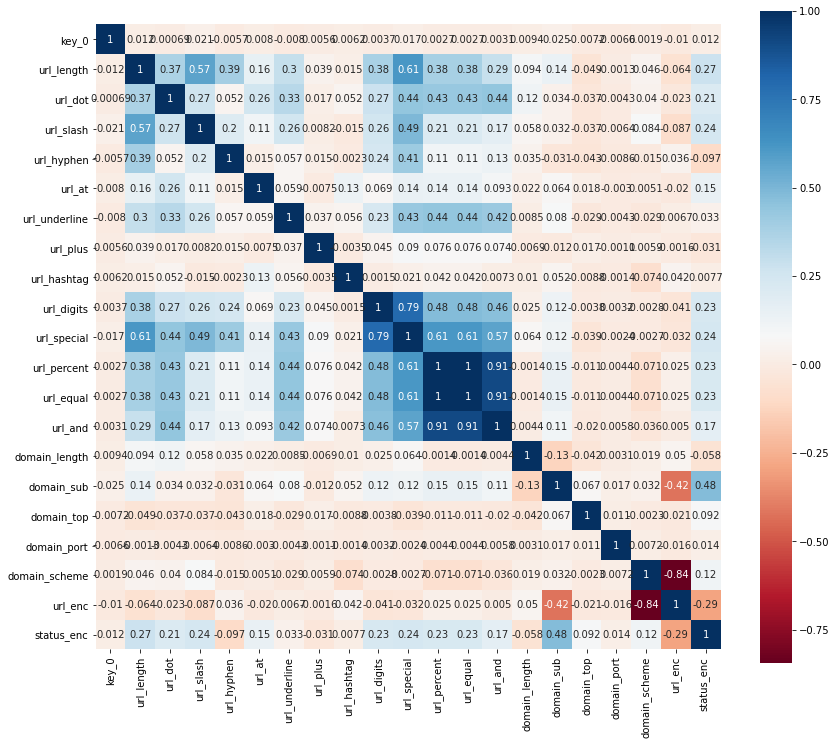

In [34]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('', y=1.05, size=15)
sns.heatmap(X_train.merge(Y_train , on = X_train.index ).corr(), 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [35]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# confusion matrix
matrix = confusion_matrix(Y_train,Y_train_tree, labels=[1,0])
print('Confusion matrix : \n',matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(Y_train,Y_train_tree,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(Y_train,Y_train_tree,labels=[1,0])
print('Classification report : \n',matrix)

Confusion matrix : 
 [[4031  574]
 [ 818 3721]]
Outcome values : 
 4031 574 818 3721
Classification report : 
               precision    recall  f1-score   support

           1       0.83      0.88      0.85      4605
           0       0.87      0.82      0.84      4539

    accuracy                           0.85      9144
   macro avg       0.85      0.85      0.85      9144
weighted avg       0.85      0.85      0.85      9144



##### True Negative - 4079
##### False Positive - 526
##### False Negative - 867
##### True Positive - 3762